In [1]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp

In [2]:
#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small  ## WHAT IS THIS
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [3]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [4]:
#simplified model
def CR_model_simple(t, y):
  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])
  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([J[i, a] for a in range(n_cs)])
    print(growth_intake, R[0])
    dNdt[i] = (N[i]*growth_intake)-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    dRdt[a] = (R0[a]-R[a])*d - consumption

  return np.concatenate((dNdt,dRdt))

In [5]:
# complete model
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])

  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)])
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    byproduction_tot = np.zeros((n_species, n_cs))
    for i in range(n_species):
      for b in range(n_cs):
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a]
    byproduction = np.sum(byproduction_tot)
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction

  return np.concatenate((dNdt,dRdt))

In [6]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [7]:
#solution of the model
solutions = solve_ivp(CR_model, t_span, y0, method = "BDF")

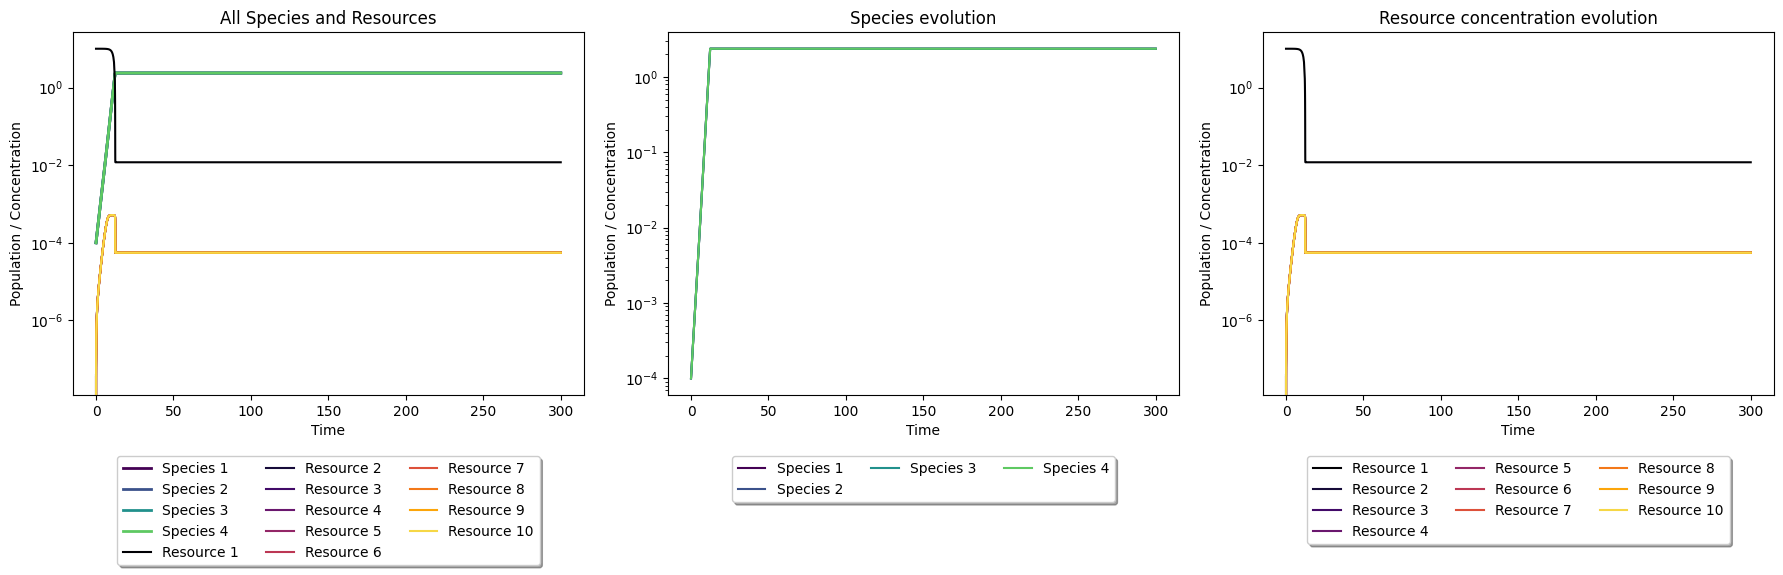

In [8]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [25]:
#Randomisation of some parameters
c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)
c

array([[0.97993902, 0.14229586, 0.90531201, 0.41261972, 0.88542613,
        0.10812781, 0.29349502, 0.71173428, 0.41144284, 0.97724235],
       [0.58839162, 0.23940569, 0.90190167, 0.01500877, 0.87921378,
        0.36439342, 0.58186158, 0.76467474, 0.28459537, 0.66441385],
       [0.89633475, 0.37220202, 0.33890869, 0.05877795, 0.39614221,
        0.20608975, 0.92255721, 0.43717423, 0.74656853, 0.53541302],
       [0.88541696, 0.47826537, 0.35084726, 0.46085274, 0.85831167,
        0.90675712, 0.0478966 , 0.44949165, 0.53661477, 0.40320155]])

In [15]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0, method = "BDF")

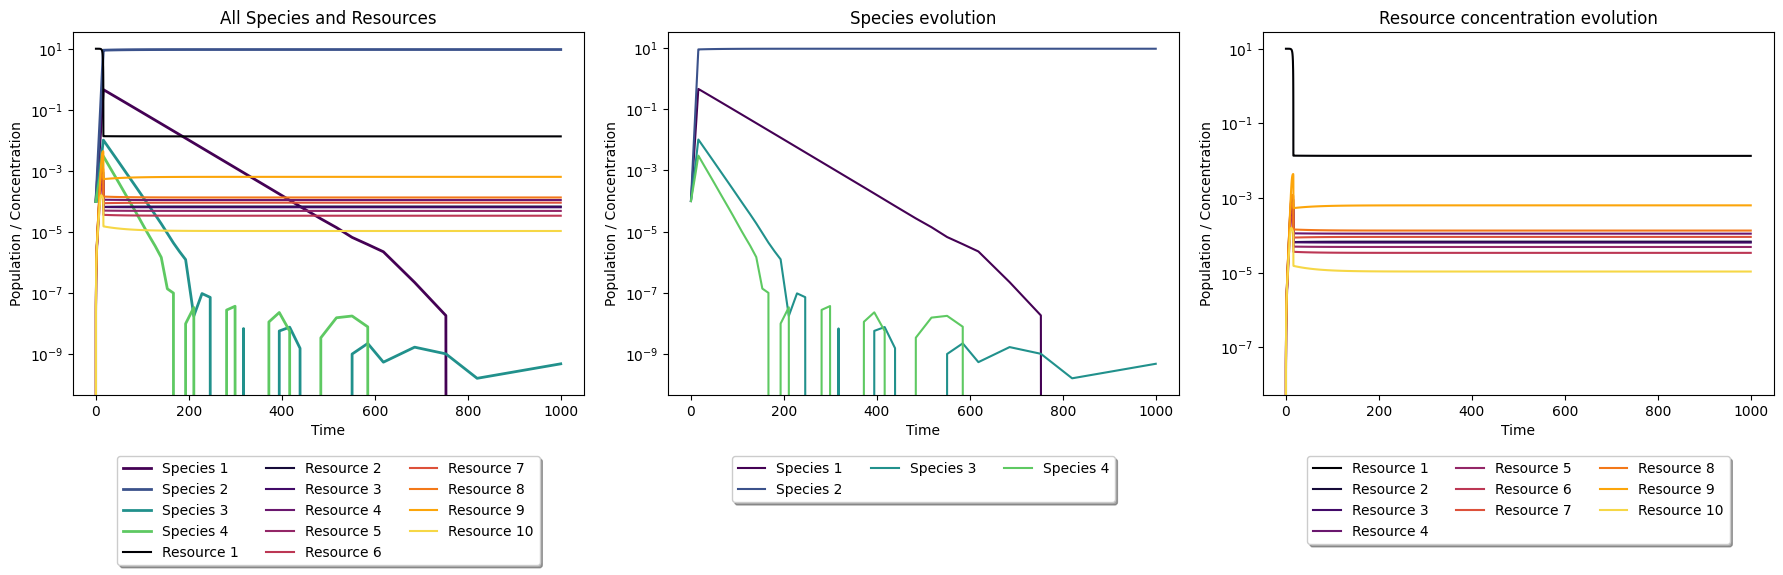

In [11]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [41]:
#random multiple simulations

sim_dict = {}
for i in range(100):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0, method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


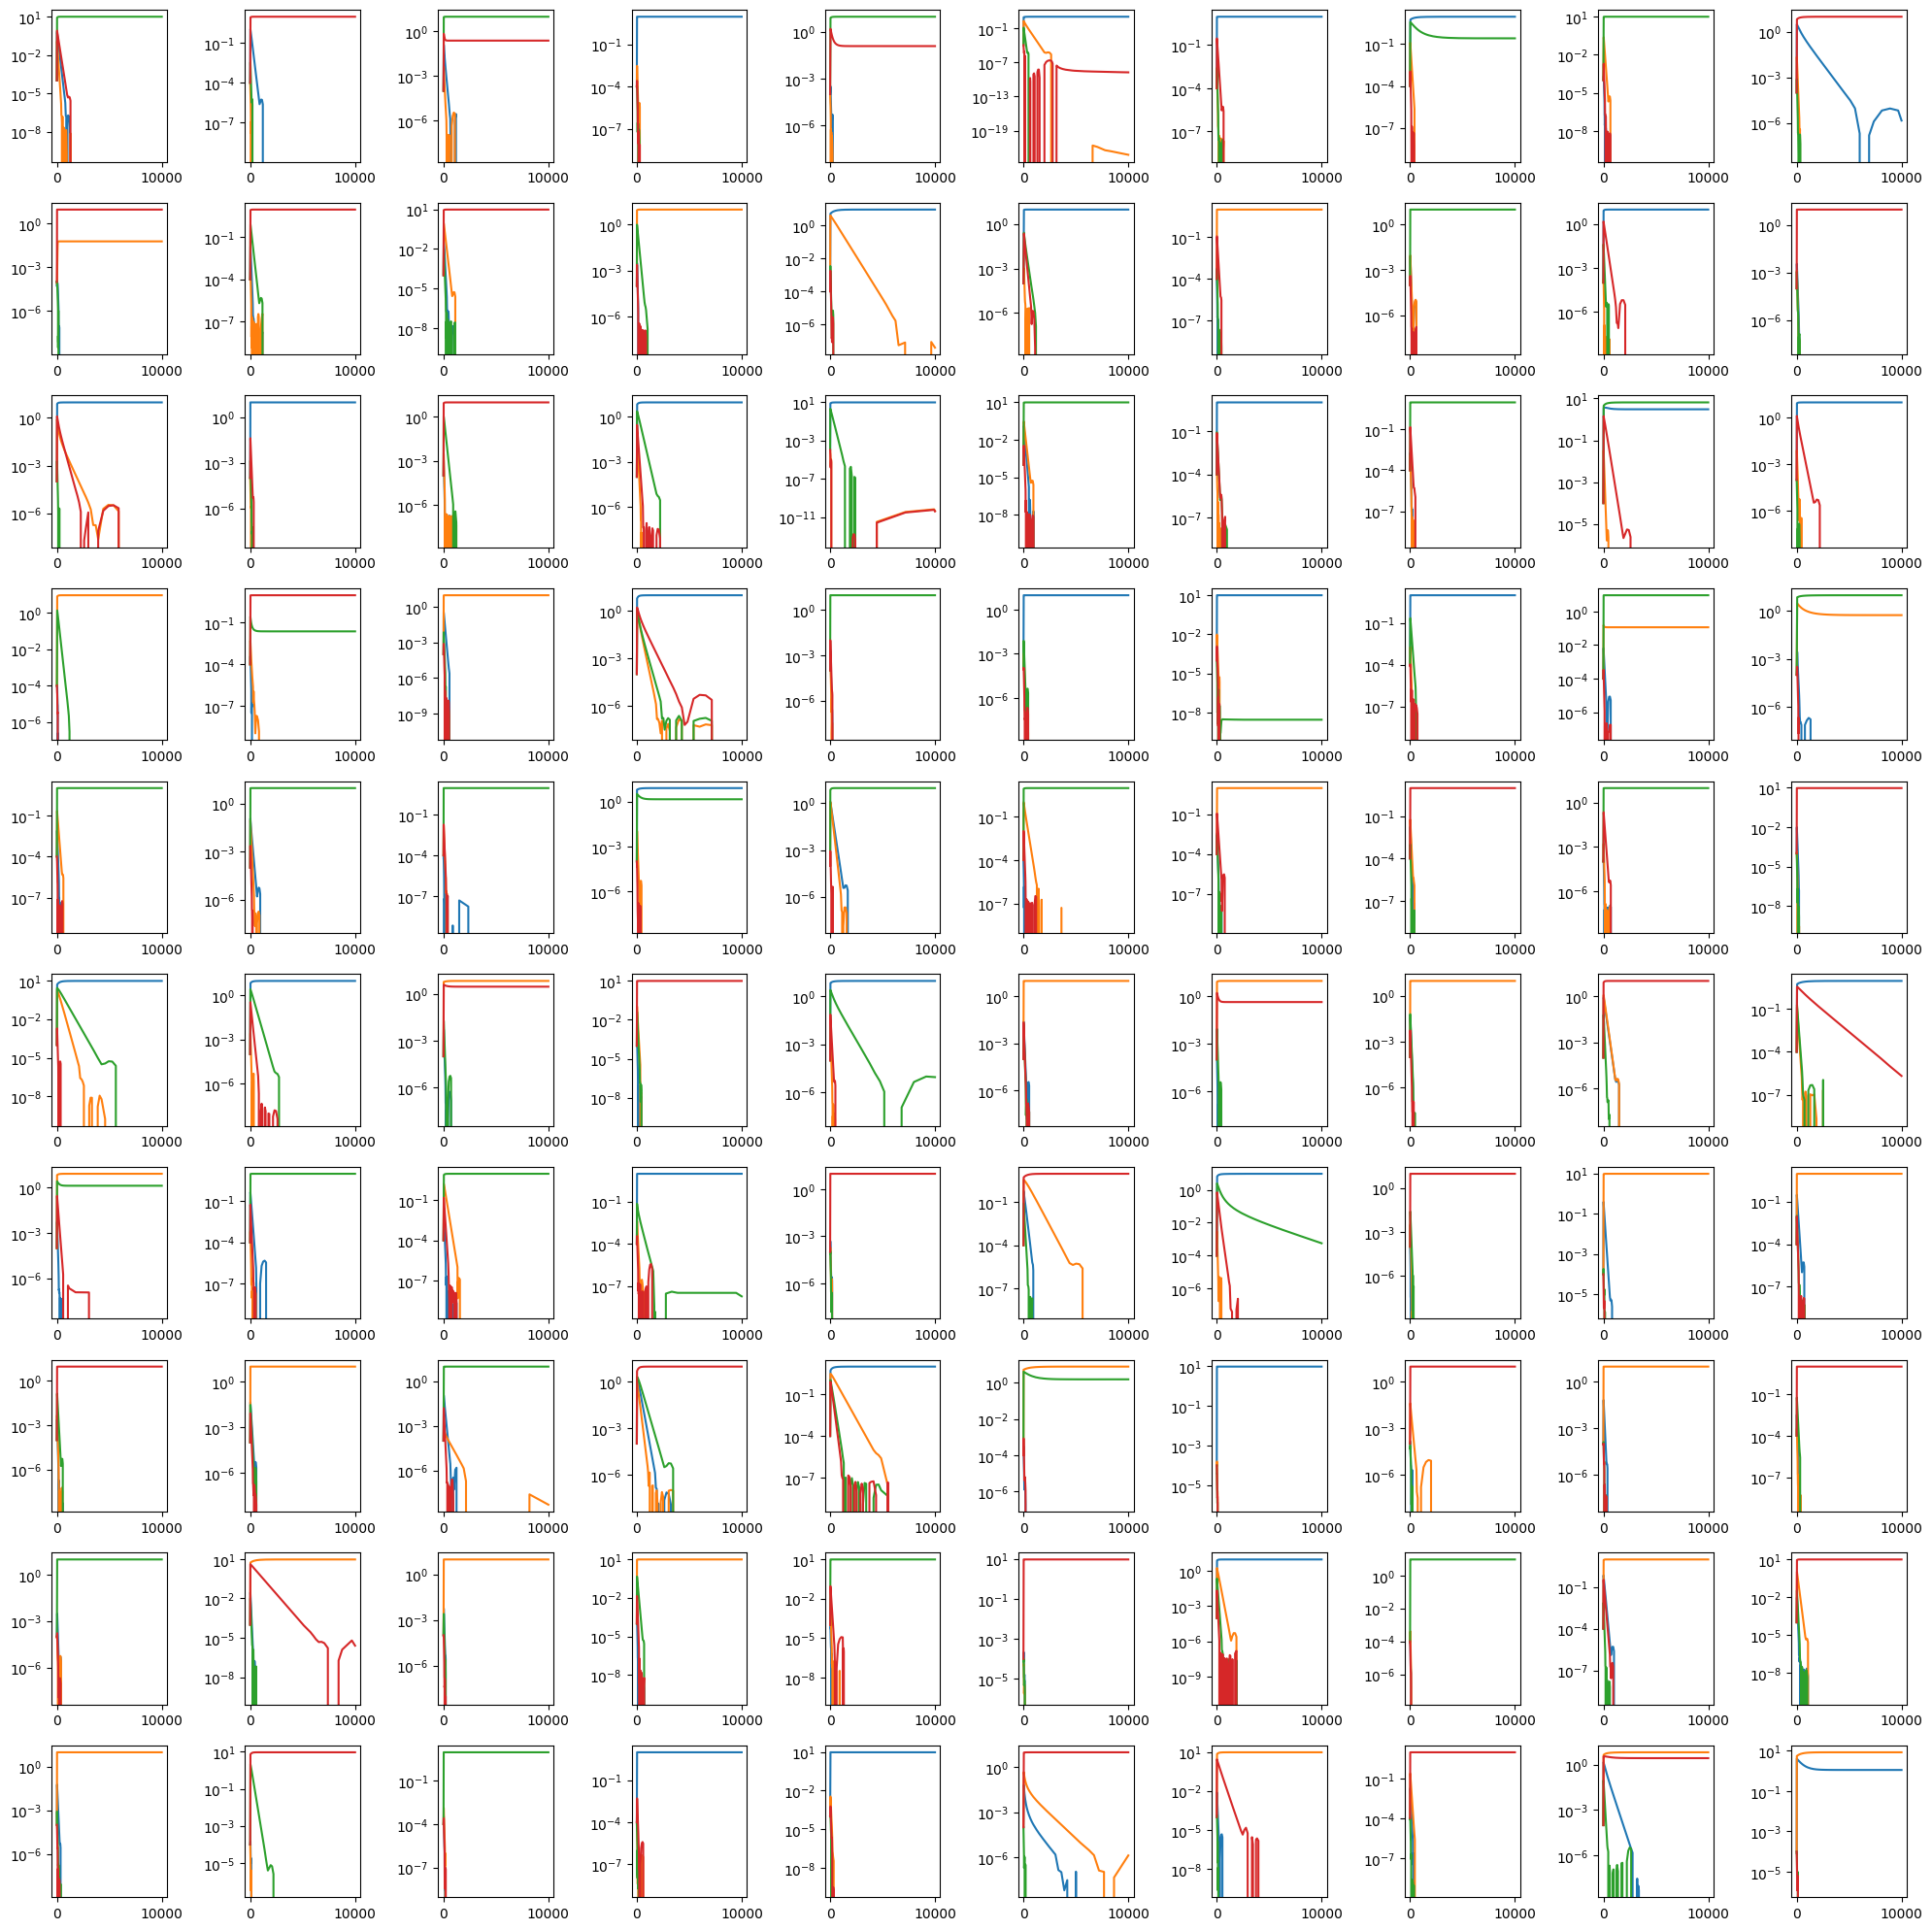

In [42]:
#plotting usinage

fig, axs = plt.subplots(10,10,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')
  ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [50]:
sim_dict['simulation 9'][1].y[0]

array([ 1.00000000e-04,  1.01398470e-04,  1.02816023e-04,  1.18897297e-04,
        1.37439159e-04,  1.95826021e-04,  2.78082325e-04,  3.94552733e-04,
        6.43000264e-04,  1.04594649e-03,  1.70078732e-03,  2.76653416e-03,
        4.51550989e-03,  7.36967941e-03,  1.20439212e-02,  1.97300874e-02,
        3.24322881e-02,  5.23465188e-02,  8.48473226e-02,  1.38165698e-01,
        2.03919431e-01,  3.01462112e-01,  4.46146085e-01,  6.60624198e-01,
        9.78169026e-01,  1.34089312e+00,  1.83520659e+00,  2.34194047e+00,
        2.41352139e+00,  2.48686493e+00,  2.56184104e+00,  2.63826142e+00,
        2.71578553e+00,  2.79374995e+00,  2.91300412e+00,  2.93766402e+00,
        2.96110121e+00,  2.98269890e+00,  3.00163755e+00,  3.01691190e+00,
        3.02514846e+00,  3.03093401e+00,  3.03460628e+00,  3.03618730e+00,
        3.03727954e+00,  3.03801586e+00,  3.03850267e+00,  3.03882319e+00,
        3.03903527e+00,  3.03925653e+00,  3.03935041e+00,  3.03936886e+00,
        3.03934621e+00,  